# Temporal analysis
## Imports

In [5]:
import pandas as pd # Pandas - Data Analysis
import matplotlib.pyplot as plt # Matplotlib - Plots
from statsforecast import StatsForecast # StatsForecast - Forecast Models
import os
import numpy as np
import itertools

/home/treeman/.local/lib/python3.11/site-packages/statsforecast/core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Variables

In [6]:
data_path = "data/chatgpt.csv"

## Loading Data

In [7]:
if not os.path.exists(data_path):
    raise FileNotFoundError('Empty path')
tweets = pd.read_csv(data_path)

## Plots 

### Tweets over time (Hour unit)

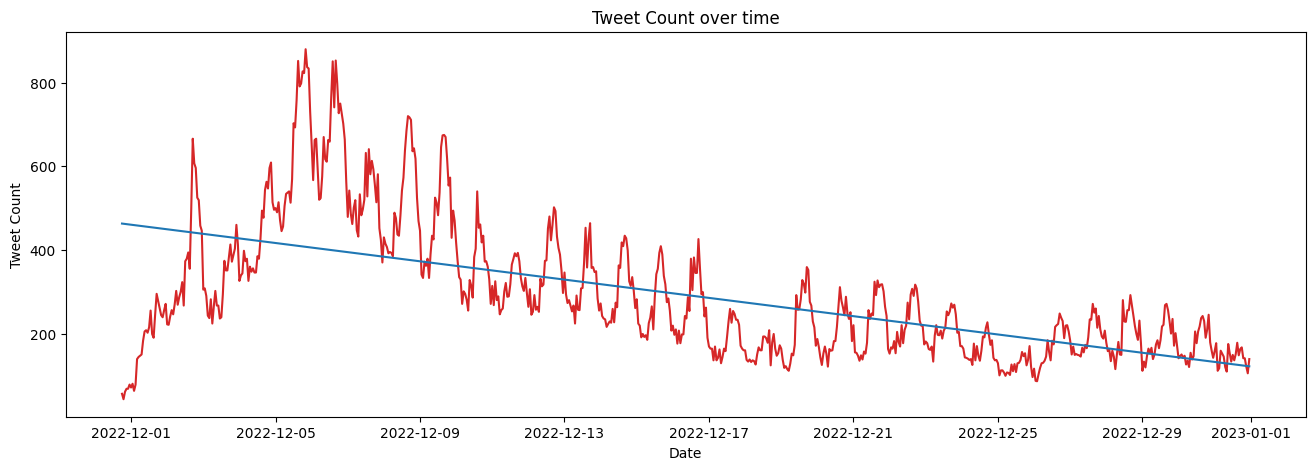

In [8]:
tweets["created_at"] = pd.to_datetime(tweets["created_at"])

tweet_count_h = tweets.groupby(pd.Grouper(key='created_at', axis=0, 
                      freq='H')).size().dropna()

tweet_count_h = tweet_count_h.reset_index()
tweet_count_h.columns = ['ds', 'tweet_count']

plt.figure(figsize=(16,5), dpi=100)
plt.plot(tweet_count_h['ds'], tweet_count_h['tweet_count'], color='tab:red')
z = np.polyfit(tweet_count_h.index, tweet_count_h['tweet_count'], 1)
p = np.poly1d(z)

plt.plot(tweet_count_h['ds'], p(tweet_count_h.index))
plt.gca().set(title="Tweet Count over time", xlabel="Date", ylabel="Tweet Count")
plt.show()


Average peek: 17.03125


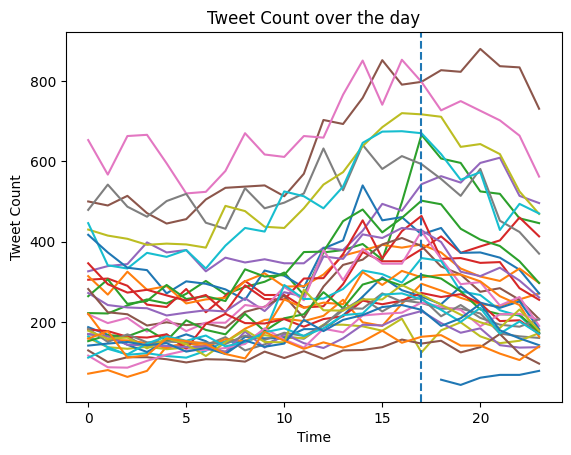

In [9]:

tweet_count_h['hour'] = tweet_count_h['ds'].dt.hour 
tweet_count_h['day'] = tweet_count_h['ds'].dt.date
daily_tweets = tweet_count_h.pivot_table(index='day', columns='hour', values='tweet_count')

avg_hour = 0
i = 0
for index, day in daily_tweets.iterrows():
    plt.plot(day.index, day.values, label=index)
    avg_hour += day.idxmax()
    i += 1

avg_hour = avg_hour / i

print("Average peek: " + str(avg_hour))

plt.gca().set(title="Tweet Count over the day", xlabel="Time", ylabel="Tweet Count")
plt.axvline(x=17, linestyle="--")
plt.show()

### Tweets over time (Day unit)

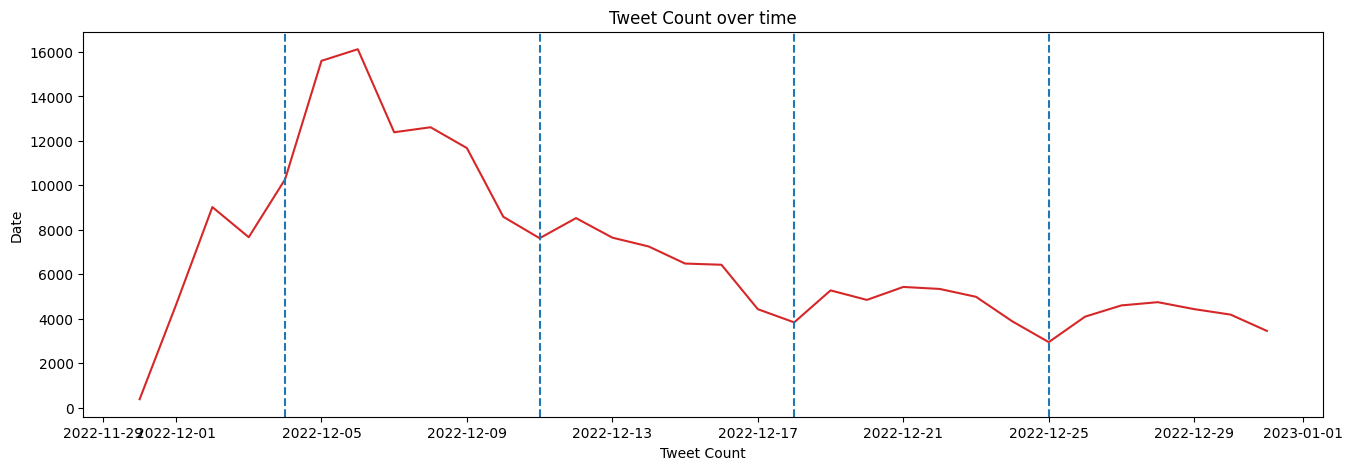

In [10]:
tweet_count_d = tweets.groupby(pd.Grouper(key='created_at', axis=0, 
                      freq='D')).size()
tweet_count_d = tweet_count_d.reset_index()
tweet_count_d.columns = ['ds', 'tweet_count']


plt.figure(figsize=(16,5), dpi=100)
plt.plot(tweet_count_d['ds'], tweet_count_d['tweet_count'], color='tab:red')
plt.gca().set(title="Tweet Count over time", xlabel="Tweet Count", ylabel="Date")
plt.axvline(x=pd.to_datetime("2022-12-04"), linestyle="--")
plt.axvline(x=pd.to_datetime("2022-12-11"), linestyle="--")
plt.axvline(x=pd.to_datetime("2022-12-18"), linestyle="--")
plt.axvline(x=pd.to_datetime("2022-12-25"), linestyle="--")
plt.show()


/tmp/ipykernel_11285/3909637761.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  tweet_count_h['week'] = tweet_count_h['ds'].dt.week


Average peek: 18.40625


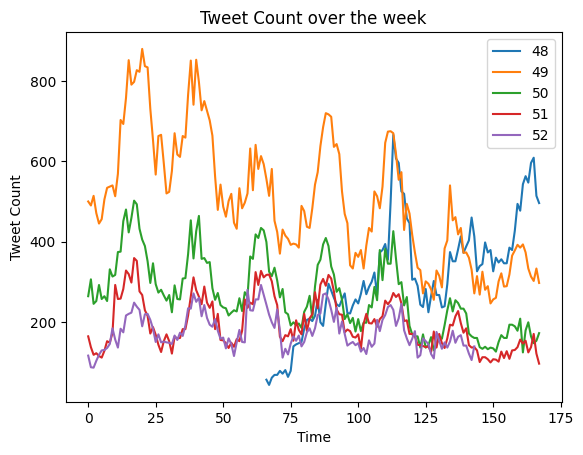

In [11]:

tweet_count_h['week'] = tweet_count_h['ds'].dt.week
tweet_count_h['weekhour'] = tweet_count_h['ds'].dt.weekday * 24 + tweet_count_h['ds'].dt.hour
weekly_tweets = tweet_count_h.pivot_table(index='week', columns='weekhour', values='tweet_count')

avg_weekhour = 0
i = 0

for index, week in weekly_tweets.iterrows():
    plt.plot(week.index, week.values, label=str(index))
    avg_hour += day.idxmax()
    i += 1

avg_hour = avg_hour / i

print("Average peek: " + str(avg_hour))

plt.gca().set(title="Tweet Count over the week", xlabel="Time", ylabel="Tweet Count")
plt.legend()
plt.show()

## ETS Models

### Imports

In [12]:
from statsforecast.models import SimpleExponentialSmoothing, SeasonalExponentialSmoothing, Holt, HoltWinters, SeasonalNaive, AutoARIMA, AutoETS, AutoRegressive, ARIMA
from statsforecast import StatsForecast
from datasetsforecast.losses import mse, mae, rmse
import statsmodels.api as sm

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for model in models:
        eval_ = df.groupby(['unique_id', 'cutoff']).apply(lambda x: metric(x['y'].values, x[model].values)).to_frame() # Calculate loss for every unique_id, model and cutoff.
        eval_.columns = [model]
        evals.append(eval_)
    evals = pd.concat(evals, axis=1)
    evals = evals.groupby(['unique_id']).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

df = pd.melt(tweet_count_h.reset_index(), id_vars=['ds'], value_vars=['tweet_count'], var_name='unique_id', value_name='y')

### STL Decomposition

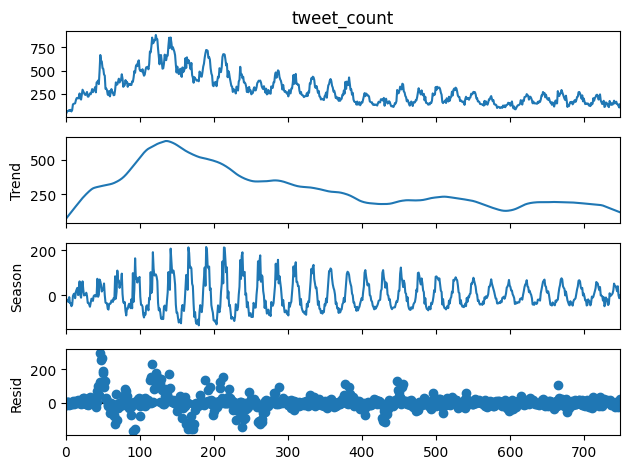

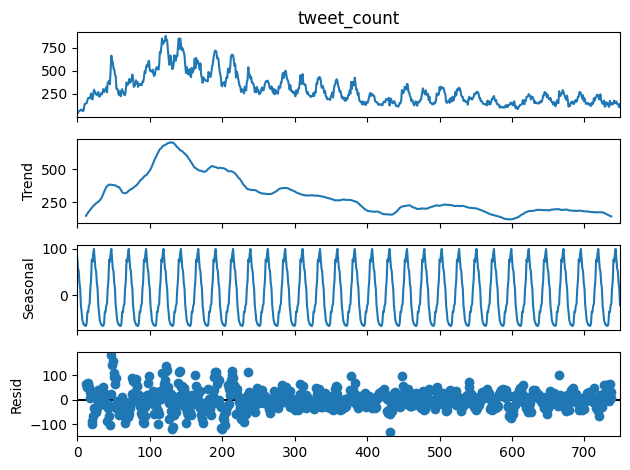

In [13]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose
res = STL(tweet_count_h['tweet_count'], period=24, robust=True).fit()
res.plot()

res = seasonal_decompose(tweet_count_h['tweet_count'], period=24, model="Multiplicative")
res.plot()
plt.show()

### ACF and PACF Plots

(-1.0928412884077214, 0.7179182569347939, 20, 729, {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}, 7330.102849003142)
(0.2569088997727408, 0.01, 17, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})


/tmp/ipykernel_11285/3572979102.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print(sm.tsa.kpss(tweet_count_h['tweet_count'], regression="ct"))


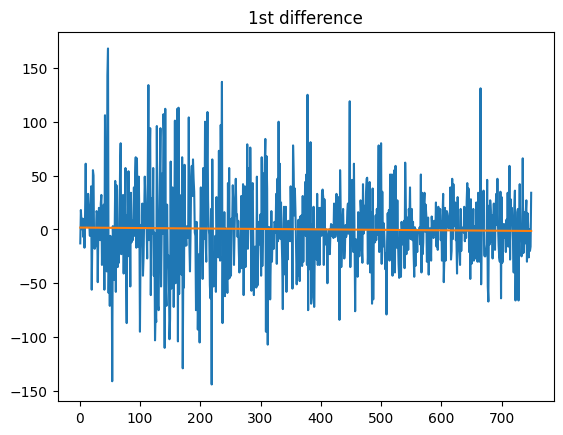

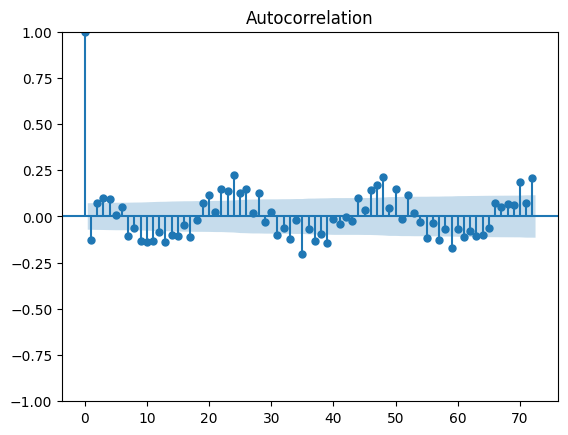

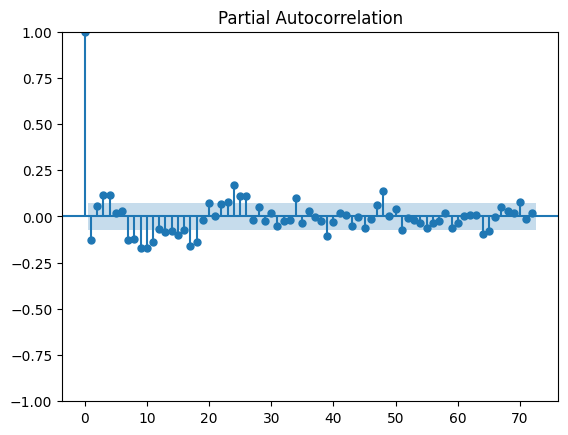

(-10.386352241985746, 2.0751747121440454e-18, 19, 729, {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}, 7320.319433073037)
(0.03040797432712009, 0.1, 10, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})


/tmp/ipykernel_11285/3572979102.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(sm.tsa.kpss(df_diff, regression="ct"))


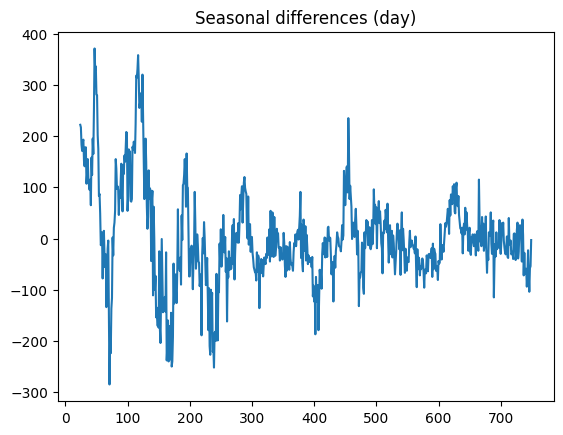

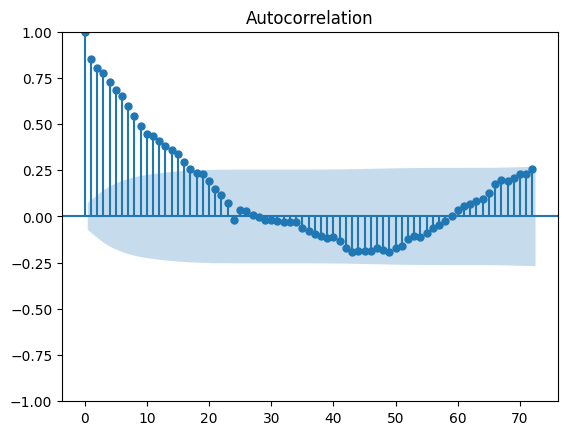

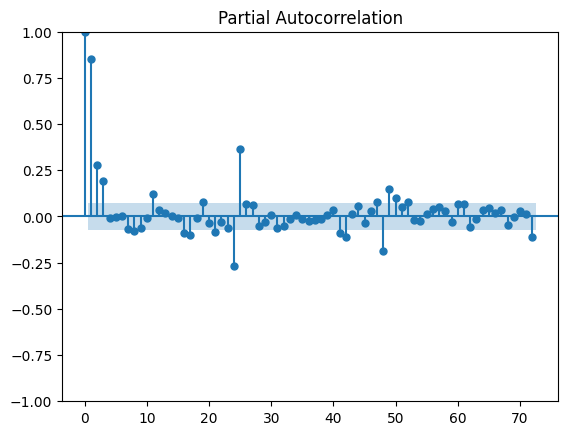

(-4.8163716099156435, 5.0596774578471724e-05, 20, 705, {'1%': -3.4396596024765795, '5%': -2.86564834926679, '10%': -2.568957779286756}, 7384.5734868252275)
(0.21435501879012878, 0.010616867953701708, 16, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})


In [14]:

print(sm.tsa.adfuller(tweet_count_h['tweet_count']))
print(sm.tsa.kpss(tweet_count_h['tweet_count'], regression="ct"))

# 1st diff
df_diff = tweet_count_h['tweet_count'].diff().dropna()
plt.plot(df_diff)
z = np.polyfit(df_diff.index, df_diff,1)
p = np.poly1d(z)

plt.plot(df_diff.index, p(df_diff.index))
plt.gca().set(title="1st difference")
plt.show()

sm.graphics.tsa.plot_acf(df_diff, lags=72)
plt.show()
sm.graphics.tsa.plot_pacf(df_diff, lags=72)
plt.show()
# ARIMA(1,1,1)

print(sm.tsa.adfuller(df_diff))
print(sm.tsa.kpss(df_diff, regression="ct"))


# Seasonal diff
df_ddiff = tweet_count_h['tweet_count'].diff(periods=24).dropna()

plt.plot(df_ddiff)
plt.gca().set(title="Seasonal differences (day)")
plt.show()

sm.graphics.tsa.plot_acf(df_ddiff, lags=72)
plt.show()
sm.graphics.tsa.plot_pacf(df_ddiff, lags=72)
plt.show()
plt.show()

print(sm.tsa.adfuller(df_ddiff))
print(sm.tsa.kpss(df_ddiff, regression="ct"))

# (2,0,0) ()


### Hyperparameter Tunning (ETS)

In [12]:
param_grid = {  
    'alpha':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

min = 99999
# Use cross validation to evaluate all parameters
for params in all_params:
    sf = StatsForecast(
        df=df, 
        models=[SimpleExponentialSmoothing(**params)],
        freq='H', 
        n_jobs=-1,
        fallback_model=SeasonalNaive(season_length=24)
    )  
    # Fit model with given params
    crossvaldation_df = sf.cross_validation(
        df=df,
        h=72,
        step_size=100,
        n_windows=4
    )

    errors = evaluate_cross_validation(crossvaldation_df, rmse)
    rmses.append(errors.loc['tweet_count', ['SES']].item())
    if(min > errors.loc['tweet_count', ['SES']].item()):
        min = errors.loc['tweet_count', ['SES']].item()
        best_params = params

print(best_params) # alpha = 0.7
i = 0.1

param_grid = {  
    'damped':[True, False],
    'season_length':[24]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

min = 99999
# Use cross validation to evaluate all parameters
for params in all_params:
    sf = StatsForecast(
        df=df, 
        models=[AutoETS(**params)],
        freq='H', 
        n_jobs=-1,
        fallback_model=SeasonalNaive(season_length=24)
    )  
    # Fit model with given params
    crossvaldation_df = sf.cross_validation(
        df=df,
        h=72,
        step_size=100,
        n_windows=5
    )

    errors = evaluate_cross_validation(crossvaldation_df, rmse)
    if(min > errors.loc['tweet_count', ['AutoETS']].item()):
        min = errors.loc['tweet_count', ['AutoETS']].item()
        best_params = params

print(best_params) # damped = True

param_grid = {  
    'error_type':["A", "M"],
    'season_length':[24]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

min = 99999
min_h = 99999
# Use cross validation to evaluate all parameters
for params in all_params:
    sf = StatsForecast(
        df=df, 
        models=[Holt(**params), HoltWinters(**params)],
        freq='H', 
        n_jobs=-1,
        fallback_model=SeasonalNaive(season_length=24)
    )  
    # Fit model with given params
    crossvaldation_df = sf.cross_validation(
        df=df,
        h=72,
        step_size=100,
        n_windows=5
    )

    errors = evaluate_cross_validation(crossvaldation_df, rmse)
    if(min > errors.loc['tweet_count', ['Holt']].item()):
        min = errors.loc['tweet_count', ['Holt']].item()
        best_params = params
    
    if(min_h > errors.loc['tweet_count', ['HoltWinters']].item()):
        min = errors.loc['tweet_count', ['HoltWinters']].item()
        best_params_w = params

print(best_params)
print(best_params_w)

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


{'alpha': 0.2}


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


{'damped': True, 'season_length': 24}


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


{'error_type': 'A', 'season_length': 24}
{'error_type': 'M', 'season_length': 24}


### Hyperparameter Tunning (ARIMA)

In [13]:
param_grid = {  
    'order':[(1,1,0), (0,1,0), (0,1,1), (0,1,2), (1, 1, 1), (2,1,2), (2,2,2), (1,1,2), (0,1,2)],
    'seasonal_order':[(1,0,1), (1,1,1), (1,0,0), (2,0,0), (2,0,1)],
    'season_length':[24]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

min = 99999
# Use cross validation to evaluate all parameters
for params in all_params:
    sf = StatsForecast(
        df=df, 
        models=[ARIMA(**params)],
        freq='H', 
        n_jobs=-1,
        fallback_model=SeasonalNaive(season_length=24)
    )  
    # Fit model with given params
    crossvaldation_df = sf.cross_validation(
        df=df,
        h=72,
        step_size=100,
        n_windows=5
    )

    errors = evaluate_cross_validation(crossvaldation_df, rmse)
    if(min > errors.loc['tweet_count', ['ARIMA']].item()):
        min = errors.loc['tweet_count', ['ARIMA']].item()
        best_params = params

print(best_params) # order = (0,1,1)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

{'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'season_length': 24}


### Models


In [18]:
models = [
    # SimpleExponentialSmoothing(alpha=0.2), 
    # SeasonalExponentialSmoothing(season_length=24, alpha=0.7), 
    # Holt(season_length=24, error_type='A'), 
    # HoltWinters(season_length=24, error_type='M'),
    # # AutoETS(season_length=24, damped=True),
    # AutoARIMA(season_length=24),
    ARIMA(order=(1,1,1), seasonal_order=(1,1,1), season_length=24),
    # SeasonalNaive(season_length=24)
]

sf = StatsForecast(
    df=df, 
    models=models,
    freq='H', 
    n_jobs=-1,
    fallback_model=SeasonalNaive(season_length=24)
)


forecast_tc = sf.forecast(h=72, level=[90])




<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


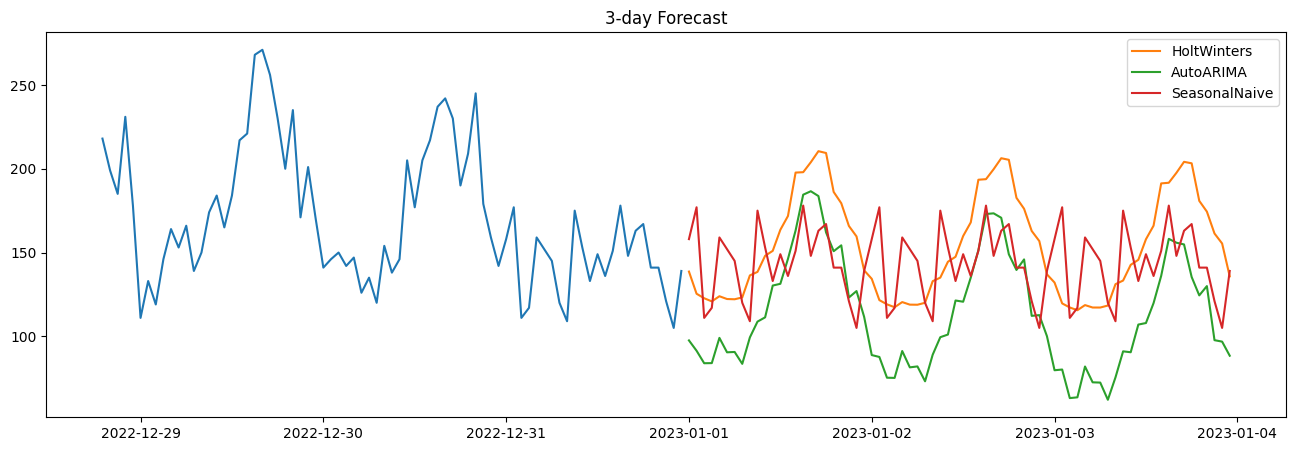

In [15]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df['ds'][(df.index > 168*4)], df['y'][(df.index > 168*4)])
plt.plot(forecast_tc['ds'], forecast_tc['HoltWinters'], label="HoltWinters")
plt.plot(forecast_tc['ds'], forecast_tc['AutoARIMA'], label="AutoARIMA")
plt.plot(forecast_tc['ds'], forecast_tc['SeasonalNaive'], label="SeasonalNaive")
plt.gca().set(title="3-day Forecast")
plt.legend()
plt.show()

### Cross Validation

In [19]:
crossvaldation_df = sf.cross_validation(
    df=df,
    h=72,
    step_size=100,
    n_windows=5
  )

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


### Evaluation

In [20]:


evaluation_mae = evaluate_cross_validation(crossvaldation_df, mae)
evaluation_mae = evaluation_mae.reset_index()
evaluation_mae['unique_id'] = evaluation_mae['unique_id'].replace(['tweet_count'], 'mae')

evaluation_mse = evaluate_cross_validation(crossvaldation_df, mse)
evaluation_mse = evaluation_mse.reset_index()
evaluation_mse['unique_id'] = evaluation_mse['unique_id'].replace(['tweet_count'], 'mse')

evaluation_rmse = evaluate_cross_validation(crossvaldation_df, rmse)
evaluation_rmse = evaluation_rmse.reset_index()
evaluation_rmse['unique_id'] = evaluation_rmse['unique_id'].replace(['tweet_count'], 'rmse')

evaluation_df = pd.merge(evaluation_mse, evaluation_mae, how='outer')
evaluation_df = pd.merge(evaluation_df, evaluation_rmse, how='outer')

print(evaluation_df)

# ARIMA 
#4875.8828125
#52.4748420715
#62.6017684937

  unique_id        ARIMA best_model
0       mse  4875.882812      ARIMA
1       mae    52.474842      ARIMA
2      rmse    62.601768      ARIMA


68.3632049561

## Prophet

In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
df['ds'] = df['ds'].dt.date
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='48 hours', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)
# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)


15:04:47 - cmdstanpy - INFO - Chain [1] start processing
15:04:47 - cmdstanpy - INFO - Chain [1] done processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] done processing
15:04:48 - cmdstanpy - INFO - Chain [1] done processing
15:04:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
15:04:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] done processing
15:

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                     0.01  234.801784
1                     0.001                     0.10  248.610322
2                     0.001                     1.00  242.609169
3                     0.001                    10.00  242.647571
4                     0.010                     0.01  175.617690
5                     0.010                     0.10  207.243324
6                     0.010                     1.00  204.421635
7                     0.010                    10.00  202.361478
8                     0.100                     0.01   78.403896
9                     0.100                     0.10  129.394542
10                    0.100                     1.00  130.838608
11                    0.100                    10.00  130.535940
12                    0.500                     0.01   85.202072
13                    0.500                     0.10  113.622854
14                    0.5

### Hyperparameter Tunning